In [3]:
import pandas as pd

data0 = pd.read_csv('interpolated_full_data.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'interpolated_full_data.csv'

In [ ]:
data = data0.drop(['F_employers',
       'M_employers', 'T_agriculture_emp', 'F_agriculture_emp',
       'M_agriculture_emp', 'T_industry_emp', 'F_industry_emp',
       'M_industry_emp', 'T_service_emp', 'F_service_emp', 'M_service_emp',
       'F_emp_ratio_15P', 'M_emp_ratio_15P', 'T_emp_ratio_15P',
       'F_emp_ratio_15_24', 'M_emp_ratio_15_24', 'T_emp_ratio_15_24',
       'F_PT_emp', 'M_PT_emp', 'T_PT_emp', 'F_self_employed',
       'M_self_employed', 'T_self_employed', 'F_adv_edu_unemp',
       'M_adv_edu_unemp', 'T_basic_edu_unemp', 'F_basic_edu_unemp',
       'M_basic_edu_unemp', 'T_int_edu_unemp', 'F_int_edu_unemp',
       'M_int_edu_unemp', 'F_unemp', 'M_unemp', 'T_unemp', 'F_youth_Unemp',
       'M_youth_Unemp', 'T_youth_Unemp', 'F_vuln_emp', 'M_vuln_emp',
       'T_vuln_emp'], axis=1)

In [ ]:
data.tail(3)

,Time Code,cty_code,T_public_edu_exp,F_bachelor_25p,M_bachelor_25p,T_bachelor_25p,F_master_25p,M_master_25p,T_master_25p,F_doctoral_25p,...,T_employers,F_paid_workers,M_paid_workers,T_paid_workers,annual_population_growth,F_population,M_population,T_population,F_survival_to_65,M_survival_to_65
184,2021,CHE,89.404282,35.349308,45.018429,40.115520,15.880310,21.542873,18.671564,2.273427,...,6.029100,86.658738,82.345775,84.359979,0.765501,4383967,4320579,8704546,94.338857,90.368386
185,2021,GBR,92.338127,40.939999,38.209999,39.590000,14.660000,14.070000,14.370000,1.170000,...,1.794410,89.639715,83.428084,86.415491,-0.081937,34044290,32982002,67026292,90.662607,85.455792
186,2021,USA,90.401039,36.116840,33.926571,35.049229,14.771294,13.632626,14.223814,1.798854,...,2.646789,95.512018,91.684526,93.416585,0.157343,165091204,166957773,332048977,84.585182,74.754549


# 라이브러리 임포트

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 타겟 설정, 학습용/테스트용 데이터 분리

In [ ]:
X = data.drop(columns=['Time Code', 'cty_code', 'T_employers'])
y = data['T_employers']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=11)

# XGBoost Regressor

In [ ]:
# 평가
def evaluate(model_name, y_true, y_pred):
    print(f"📌 {model_name} 결과")
    print(f"  R²   : {r2_score(y_true, y_pred):.4f}")
    print(f"  MSE  : {mean_squared_error(y_true, y_pred):.4f}")
    print(f"  RMSE : {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print()

In [ ]:
xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=11)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

evaluate("XGBoost", y_test, xgb_pred)

📌 XGBoost 결과
  R²   : 0.9274
  MSE  : 0.1754
  RMSE : 0.4188



## 피처 중요도 시각화

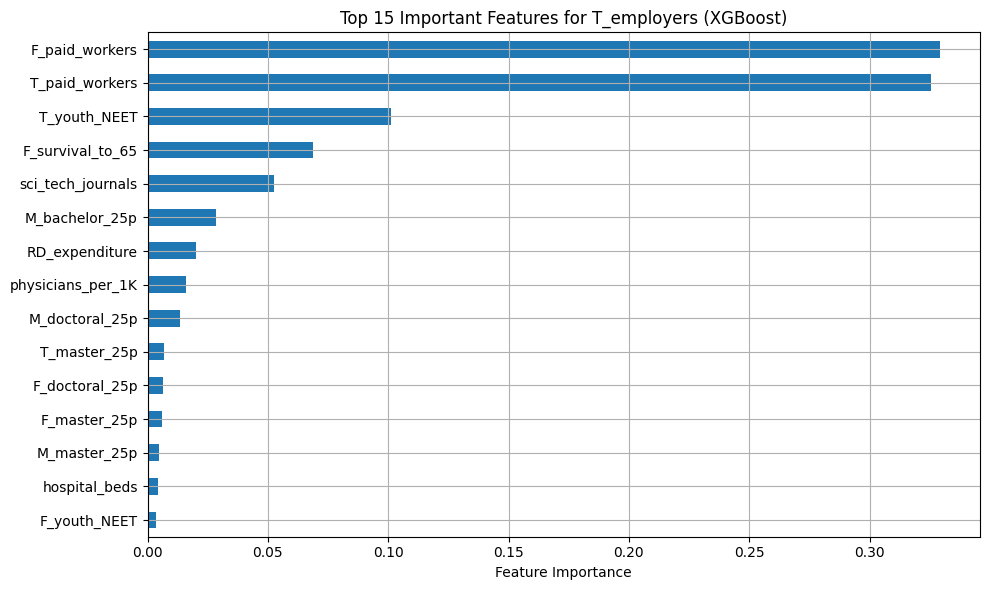

In [ ]:
importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
top_features.plot(kind='barh')
plt.title("Top 15 Important Features for T_employers (XGBoost)")
plt.xlabel("Feature Importance")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

XGBoostRegressor의 피처 중요도를 시각화해본 결과 **F_paid_workers, T_paid_workers, T_youth_NEET**가 상위 3개로 나옴

1. **F_paid_workers**: 여성 노동참여 중에서도 특히 '정규직/임금근로자' 비율이 높을수록 전체 고용자 수에 긍정적인 영향을 미침. 고용자 수가 높은 국가는 단순히 여성 참여율만 높은 것이 아니라, 질 좋은 일자리에 여성들이 더 많이 진입하고 있음을 의미.
- 한국 시사점: 여성 고용의 양보다 질 개선 필요 -> 성별 임금격차 해소, 경력단절 예방
2. **T_paid_workers**: 유급근로자(정규직/임금 노동자)가 전체 노동자 중 많을수록 T_employers 높아짐. 자영업보다 기업이나 조직에 고용되어 일하는 사람이 많은 국가일수록 고용 안정성과 총 고용자 수가 높음
- 한국 시사점: 자영업/비정규직 비중을 줄이고, 유급근로자 증가를 위한 기업 일자리 창출 정책 강화
3. **T_youth_NEET**: T_youth_NEET 비율이 높을수록 T_employers는 낮아지는 경향이 있음. 이는 청년 니트가 많다는 건 청년들이 노동시장에 진입을 실패한다는 의미이고, 장기적으로 전체 고용자 수에 악영향을 미친다는 것임.
- 한국 시사점: 청년 고용 문제의 심각성을 강조하고 진로 교육, 취업 연계 훈련, 스타트업 지원 등 청년 맞춤형 정책 강화가 필요함.

☑️ 한국에 적용할 정책 제안
- 여성의 육아휴직 후 복귀 지원, 경력단절 방지 인센티브
- 비정규직의 정규직 전환 유도 및 기업 지원금 확대
- 청년 대상 직업 훈련 프로그램 + 청년 인턴십/스타트업 창업 지원

# 고용률 높은 국가

In [ ]:
# 최근 연도 확인
latest_year = data['Time Code'].max()

# 해당 연도 기준 데이터 추출
latest_data = data[data['Time Code'] == latest_year]

# T_employers 기준 정렬 (고용률 높은 국가 찾기)
top_employers = latest_data[['cty_code', 'T_employers']].sort_values(by='T_employers', ascending=False)

# 상위 10개 국가 출력
top_employers.head(9)

,cty_code,T_employers
171,AUT,6.223794
178,ITA,6.212315
184,CHE,6.029100
176,FRA,4.941700
170,AUS,4.890054
182,ESP,4.858276
179,KOR,4.792589
177,DEU,4.027615
173,CAN,3.891236
172,BEL,3.501276


<ipython-input-11-fc3cc06c7495>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_employers.head(10), x='cty_code', y='T_employers', palette='viridis')


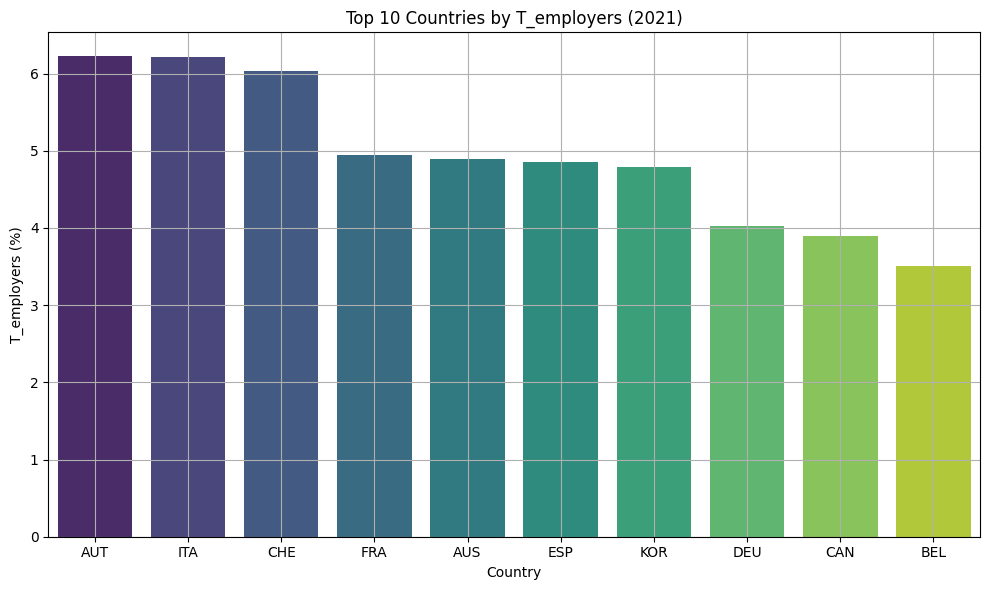

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=top_employers.head(10), x='cty_code', y='T_employers', palette='viridis')
plt.title(f'Top 10 Countries by T_employers ({latest_year})')
plt.xlabel('Country')
plt.ylabel('T_employers (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 고용률 상위 국가 간의 중요 변수 값 차이 비교

<ipython-input-12-37601f45c757>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x='cty_code', y=var, palette='Set2')


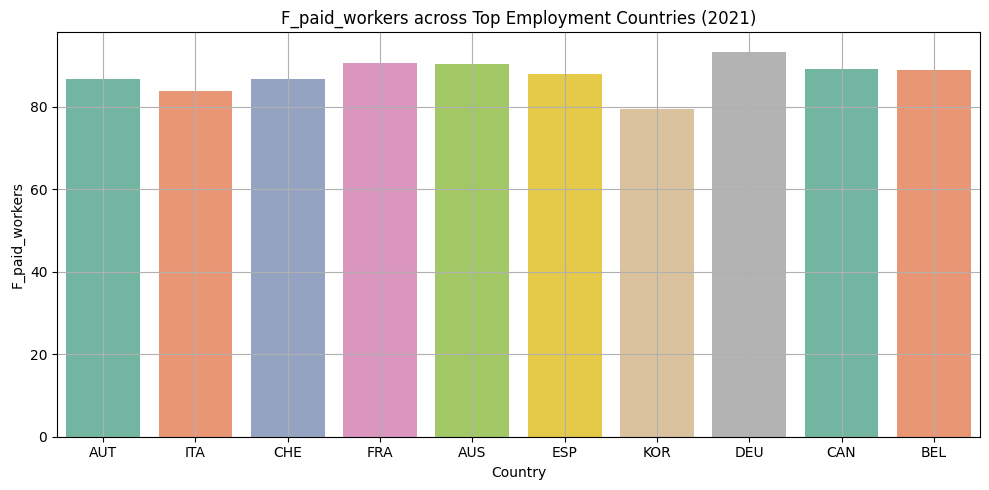

<ipython-input-12-37601f45c757>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x='cty_code', y=var, palette='Set2')


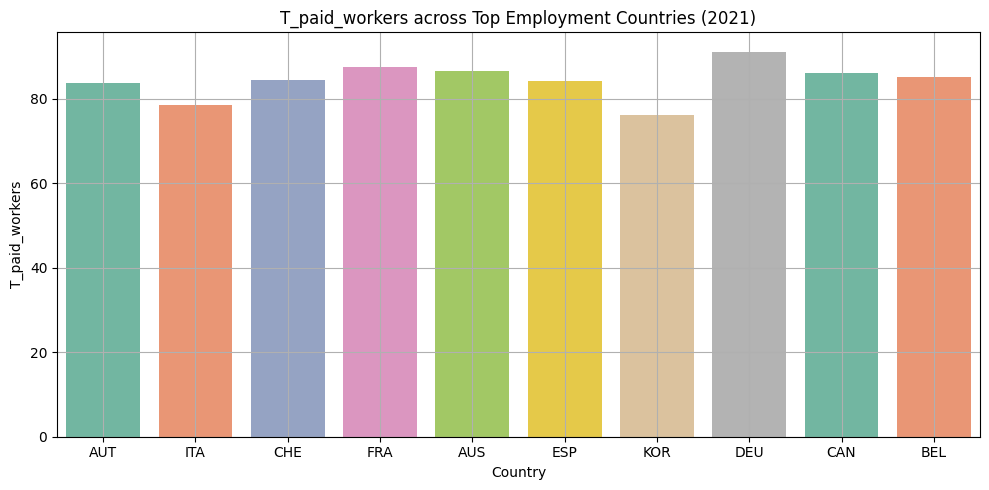

<ipython-input-12-37601f45c757>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x='cty_code', y=var, palette='Set2')


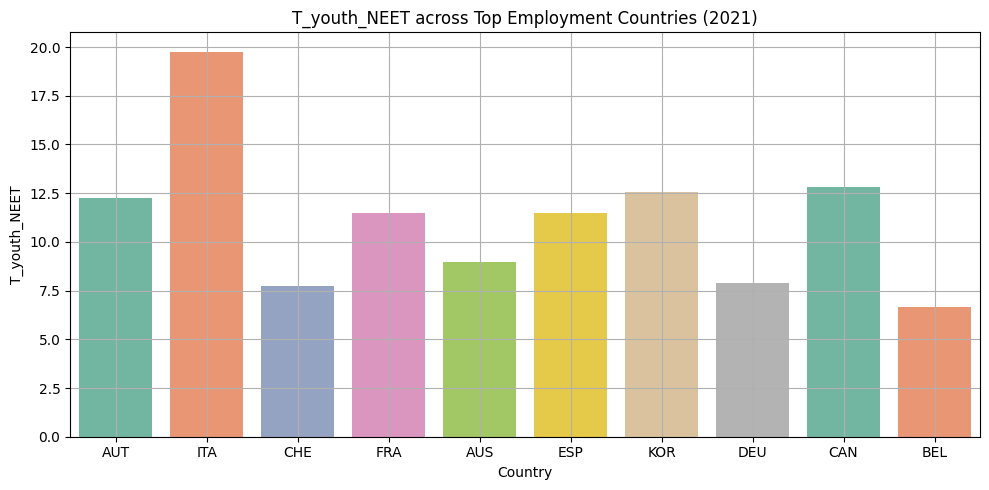

<ipython-input-12-37601f45c757>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x='cty_code', y=var, palette='Set2')


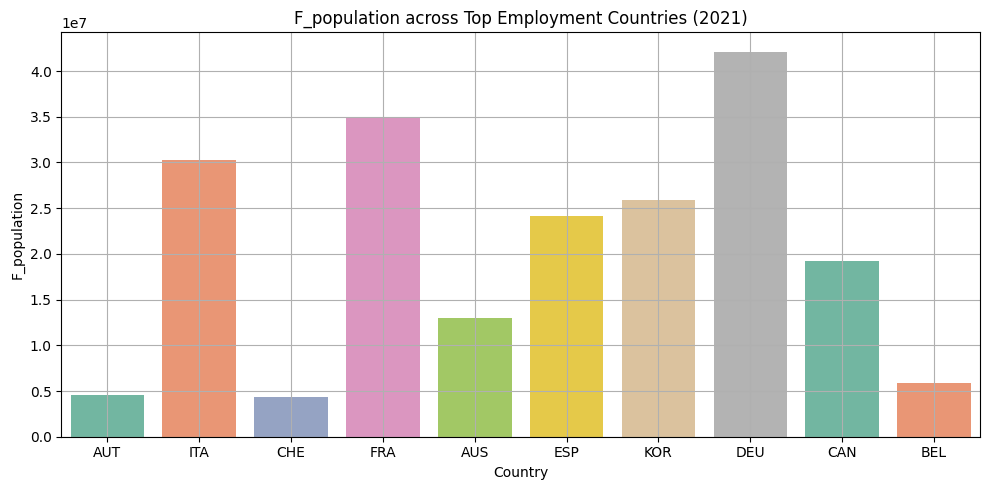

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 고용률 상위 국가 리스트
top_countries = ['AUT', 'ITA', 'CHE', 'FRA', 'AUS', 'ESP', 'KOR', 'DEU', 'CAN', 'BEL']

# 중요 변수
important_vars = ['F_paid_workers', 'T_paid_workers', 'T_youth_NEET','F_population']

# 최신 연도 데이터만 필터링
latest_year = data['Time Code'].max()
latest = data[data['Time Code'] == latest_year]

# 상위 국가 + 중요 변수만 추출
subset = latest[latest['cty_code'].isin(top_countries)][['cty_code', 'T_employers'] + important_vars]

# 정렬: 고용률 기준
subset = subset.sort_values('T_employers', ascending=False)

# 변수별 시각화
for var in important_vars:
    plt.figure(figsize=(10, 5))
    sns.barplot(data=subset, x='cty_code', y=var, palette='Set2')
    plt.title(f'{var} across Top Employment Countries ({latest_year})')
    plt.xlabel('Country')
    plt.ylabel(var)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

1. **F_paid_workers(여성 유급근로자 비율)**: 다른 상위 국가들에 비해 가장 낮음. 이는 한국 여성 고용률이 OECD 31위, 20년간 하위권이라는 통계자료를 통해 알 수 있음.
- 정책 시사점: 경력단절 예방, 출산/육아 후 복귀 지원, 유연근무제 확대 등을 통해 여성의 안정적 노동시장을 위한 노력이 필요

2. **T_paid_workers(전체 유급근로자 비율)**: 다른 상위 국가들에 비해 가장 낮음. 이 비율이 낮다는 것은 자영업, 비임금 노동자의 비중이 크다고 볼 수 있음.
- 정책 시사점: 유급근로자 확대를 위한 정책(정규직 채용 확대, 기업 고용 인센티브 등)이 필요

3. **T_youth_NEET(청년 니트 비율)**: 평균보다 높은 수치. 니트 비율이 높다는 것은 미래 노동시장 유입이 약하다는 뜻이고 이는 T_employers에 장기적으로 악영향을 끼침.
- 정책 시사점: 청년층의 취업 유도 및 진로 교육, 인턴십, 직업 훈련 강화 필요

4. **F_population(여성 인구 수)**: 여성 인구 수가 매우 적은 나라와 많은 나라 모두 상위 국가에 포함되어 있으므로 여성 인구 수는 고용률과 직접적인 상관관계가 아님. 즉, 여성 인구 수는 고용률의 규모에는 영향을 미치지만 비율에는 직접적인 영향을 주진 않음.
- 하지만 한국은 여성 인구는 상위권이나 F_paid_workers가 가장 낮았음.
- 독일은 여성 인구도 많고 F_paid_workers도 높았음. 이를 통해 고용률에 긍정적 이중 효과가 나타났음

📌 따라서 한국은 여성 인구 규모는 충분하지만 활용이 부족함 -> 여성의 경제활동 참여 확대가 고용률 향상의 핵심 !

# 한국 데이터

📌 결론 도출

전반적으로 예측값이 실제값을 잘 따라감. 하락 추세는 따라가지만, 실제 하락폭보다 작게 예측함. XGBoost에 비해 보수적인 예측, 더 안정적인 추세를 보임. 코로나 이후 급락한 고용률을 보완하기 위해서는 단기 정책보다 구조 개선 중심의 장기 전략이 중요함.

## XGBoost 모델

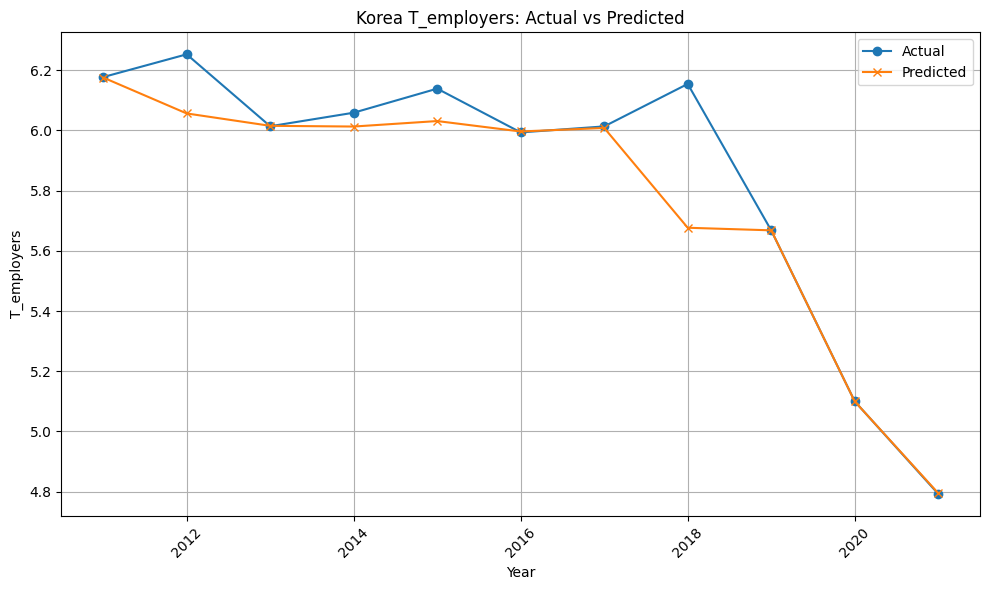

In [ ]:
# 한국 데이터에 적용
korea_data = data[data['cty_code'] == 'KOR'].copy()
korea_data = korea_data.dropna(subset=X.columns)
korea_X = korea_data[X.columns]
korea_y = korea_data['T_employers']
korea_years = korea_data['Time Code']
korea_pred = xgb_model.predict(korea_X)

# 한국 예측 vs 실제 시각화
plt.figure(figsize=(10, 6))
plt.plot(korea_years, korea_y, label='Actual', marker='o')
plt.plot(korea_years, korea_pred, label='Predicted', marker='x')
plt.title("Korea T_employers: Actual vs Predicted")
plt.xlabel("Year")
plt.ylabel("T_employers")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

📌 결론 도출

1. XGBoost 회귀 모델은 T_employers의 시간적 추세와 수준을 잘 반영하고 있는 것을 알 수 있음.
2. 2018년 이후로 고용자 수 급감. 이는 2019년부터 시작된 코로나의 영향이 큰 것으로 예측해볼 수 있음
3. 중요한 피처였던 F_paid_workers, T_paid_workers, T_youth_NEET에 대한 정책적 개입이 고용률을 다시 올릴 수 있는 열쇠가 될 수 있음

# 최종 결론

한국은 고용률 상위 국가들에 비해 T_paid_workers(유급근로자 비율), F_paid_workers(여성 유급근로자 비율), T_youth_NEET(청년 니트율) 등 핵심 변수에서 불리함. 이 변수들은 XGBoost, RandomForest 분석에서도 고용자 수에 중요한 영향을 미치는 것으로 나타났음.

<한국이 고용률을 높이기 위해서는 정책적 개선이 필요>

☑️ 유급근로자 비율 낮음 -> 기업의 정규직 채용 확대, 기업 고용 인센티브 확대 필요

☑️ 여성 유급근로자 비율 낮음 -> 경력단절을 지원하기 위한 법을 만들어 육아휴직 보장, 여성 채용 비율 설정 등의 정책 추진 필요

☑️ 청년 NEET 비율 높음 -> 진로 교육, 청년 직업훈련 등의 활동 필요
